# In which cases is PE better than MSR and why?

CIFAR 100 ViT, jeweils für alle shifts (bei corruption recht level 3):

- Run the following analysis analysis for one job (that is representative
  for the mean performance of PE and MSR over 5 jobs).
  - Filter 20 cases for which (rank_MSR - rank_PE) is highest (MSR descending,
    PE ascending) and y_f=0, and 20 for which this term is most negative and
    y_f=1.
  - Print for all 40 cases: MSR score, PE score, MSR distance to second
    largest class, MSR rank (among all MSR scores descending), PE rank (among
    all PE scores ascending), Softmax vector

In [23]:
from functools import cached_property
from itertools import product
from pathlib import Path
from typing import Any, Optional

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
from IPython import get_ipython
from omegaconf import OmegaConf

from fd_shifts.loaders.abstract_loader import AbstractDataLoader

IS_IPYTHON = bool(get_ipython())

if IS_IPYTHON:
    from IPython.display import Markdown, display

    pprint = display
else:
    from rich import print as pprint
    from rich.markdown import Markdown


def entropy_fct(x):
    return -np.sum(x * np.log(x, where=x > 0), axis=-1)


def generate_entropy_range(msr, num_classes):
    restprob = 1 - msr
    max_ent_softmax = np.ones((msr.shape[0], num_classes), dtype=np.float64)
    max_ent_softmax[:, 0] = msr
    fill_vals = restprob / (num_classes - 1)
    for row in range(max_ent_softmax.shape[0]):
        max_ent_softmax[row, 1:] = fill_vals[row]
    max_ent = entropy_fct(max_ent_softmax)

    columns = [msr, np.ones_like(msr) * restprob]

    # min_ent_softmax = np.ones((msr.shape[0], num_class), dtype=np.float64)
    # max_ent_softmax[:, 0] = msr
    # max_ent_softmax[:, 1] = restprob
    for num_class in range(2, num_classes):
        # get values with overlflow where p_{i+1} < p_i
        mask = columns[num_class - 1] > columns[num_class - 2]
        # compute overflow
        overflow = columns[num_class - 1][mask] - columns[num_class - 2][mask]
        # set values
        columns[num_class - 1][mask] = columns[num_class - 2][mask]

        # create new columnt
        new_col = np.zeros_like(msr)
        # add values to columns from overflow
        new_col[mask] = overflow
        columns.append(new_col)
    min_ent_softmax = np.stack(columns, axis=1)

    min_ent = entropy_fct(min_ent_softmax)
    return max_ent, min_ent


def generate_entropy_plot(num_classes, stepsize):
    """Returns the entropies and msrs for a boundary plot
    of possible values.

    Args:
        num_classes (_type_): _description_
        stepsize (_type_): _description_

    Returns:
        _type_: _description_
    """
    min_val = 1 / num_classes
    min_val -= min_val % stepsize
    msrs = np.arange(min_val, 1 + stepsize / 2, stepsize)
    max_ent, min_ent = generate_entropy_range(msrs, num_classes)
    msrs_plot = np.concatenate([msrs, msrs[::-1]])
    ent_plot = np.concatenate([max_ent, min_ent[::-1]])
    return ent_plot, msrs_plot


class DatasetCache:
    def __init__(self, cfg):
        self.cfg = cfg

    @cached_property
    def _dataloaders(self):
        dataloader = AbstractDataLoader(self.cfg)
        dataloader.prepare_data()
        dataloader.setup()
        return dataloader.test_dataloader()

    def __getitem__(self, i):
        return self._dataloaders[i].dataset


def extract_hparam(name: pd.Series, regex: str) -> pd.Series:
    return name.str.replace(".*" + regex + ".*", "\\1", regex=True)


def load_metrics_csvs(dataset: str, base_path: Path) -> pd.DataFrame:
    data = pd.concat(
        [pd.read_csv(p) for p in base_path.glob(f"{dataset}_*/test_results/*.csv")]
    )[["name", "study", "confid", "accuracy", "failauc", "aurc", "ece"]]

    data = data.assign(
        model=lambda row: extract_hparam(row.name, r"model([a-z]+)"),
        bb=lambda row: extract_hparam(row.name, r"bb([a-z0-9]+(_small_conv)?)"),
        lr=lambda row: extract_hparam(row.name, r"lr([0-9.]+)"),
        bs=lambda row: extract_hparam(row.name, r"bs([0-9]+)"),
        run=lambda row: extract_hparam(row.name, r"run([0-9]+)"),
        do=lambda row: extract_hparam(row.name, r"do([01])"),
        rew=lambda row: extract_hparam(row.name, r"rew([0-9.]+)"),
    )

    return data


def clean_metrics_data(data: pd.DataFrame) -> pd.DataFrame:
    metric = "aurc"
    selection_df = data[(data.study == "val_tuning")][
        ["name", "confid", "lr", "do", "run", "bb", metric]
    ]
    selection_df = selection_df.iloc[
        selection_df.groupby(["confid", "do"])[metric].idxmin()
    ]

    def _select_func(row, selection_df, selection_column):
        selection_df = selection_df[
            (selection_df.confid == row.confid)  # & (selection_df.do == row.do)
        ]

        return row[selection_column] == selection_df[selection_column].tolist()[0]

    data = data[
        data.apply(lambda row: _select_func(row, selection_df, "lr"), axis=1) == 1
    ]

    data = data.assign(
        study=data.study.str.replace("noise_study.*", "noise_study", regex=True)
    )

    return data


def report_metrics(data: pd.DataFrame):
    results = data.groupby(["study", "confid", "do"]).mean().reset_index()

    return (
        results.iloc[results.groupby(["study", "confid"])["aurc"].idxmin()]
        .sort_values(["study", "aurc"])
        .reset_index(drop=True)
    )


def find_representative_run(data: pd.DataFrame) -> str:
    rep = (
        data[(data.study == "val_tuning") & (data.confid == "det_pe")]
        .sort_values("aurc")
        .reset_index(drop=True)
    )
    rep_name = rep.iloc[len(rep) // 2]["name"]

    return rep_name


def maximum_softmax_probability(softmax: npt.NDArray[Any]) -> npt.NDArray[Any]:
    return np.max(softmax, axis=1)


def predictive_entropy(softmax: npt.NDArray[Any]) -> npt.NDArray[Any]:
    return np.sum(softmax * (-np.log(softmax + 1e-7)), axis=1)


def load_raw_outputs(experiment_name: str, base_path: Path) -> pd.DataFrame:
    # Data format see readme
    output = np.load(base_path / experiment_name / "test_results/raw_output.npz")[
        "arr_0"
    ]
    data = pd.DataFrame(
        output,
        columns=[
            *(("softmax", i) for i in range(output.shape[1] - 2)),
            ("label", ""),
            ("dataset", ""),
        ],
        dtype=np.float64,
    )
    data.columns = pd.MultiIndex.from_tuples(data.columns)

    data = data[data.dataset == 1].reset_index(drop=True)

    data = data.assign(dataset_idx=data.index)

    return data


def load_config(experiment_name: str, base_path: Path):
    return OmegaConf.load(base_path / experiment_name / "hydra/config.yaml")


def add_confid_scores(data: pd.DataFrame) -> pd.DataFrame:
    data = data.assign(
        msr=maximum_softmax_probability(data.softmax),
        pe=predictive_entropy(data.softmax),
        f_label=(data.label == data.softmax.to_numpy().argmax(axis=1)),
    )

    # argsort sorts ascending, sort_values too
    # => higher rank means higher confidence (rank 0 is lowest confidence sample)
    idx_sorted_msr = data.msr.argsort()
    idx_sorted_pe = (-data.pe).argsort()
    data = data.assign(
        msr_rank=idx_sorted_msr.sort_values().index,
        pe_rank=idx_sorted_pe.sort_values().index,
    )

    return data


def compute_comparisons(data: pd.DataFrame) -> pd.DataFrame:
    """Returns data sorted by difference in msr rank and pe rank.

    Since it's sorted ascending, the first samples have high pe confidence and
    low msr confidence. The last samples have low pe confidence and hight msr
    confidence.
    """

    data = (
        data.assign(rank_diff=data.msr_rank - data.pe_rank)
        .sort_values("rank_diff")
        .reset_index(drop=True)
        .drop(columns=["dataset", "rank_diff"], level=0)
        .assign(
            msr_to_second=lambda d: np.abs(
                np.sort(d.softmax.to_numpy(), axis=1)[:, -2] - d.msr
            )
        )
    )
    return data


def get_top_ranked(
    data: pd.DataFrame, metric: str, f_label: bool, n: int = 10
) -> pd.DataFrame:
    if metric == "pe":
        return data[data.f_label == f_label][:n]

    if metric == "msr":
        return data[data.f_label == f_label][-n:]

    raise ValueError


def H1(text: str) -> None:
    pprint(Markdown(f"# {text}"))


def H2(text: str) -> None:
    pprint(Markdown(f"## {text}"))


def _report_top_ranked(data: pd.DataFrame, high_score: str, f_label: bool):
    low_score = {
        "pe": "msr",
        "msr": "pe",
    }

    H1(
        f"High {high_score} rank, low {low_score[high_score]} rank (classifier {'success' if f_label else 'failure'}):"
    )
    pprint(
        get_top_ranked(data, high_score, f_label)
        .style.background_gradient(
            axis=1, subset="softmax", vmin=0, vmax=1, cmap="Oranges"
        )
        .background_gradient(subset="f_label", cmap="PiYG", vmin=0, vmax=1)
    )


def _plot_scatter_top_ranked(
    data: pd.DataFrame, high_score: str, f_label: bool, ax: plt.Axes
):
    low_score = {
        "pe": "msr",
        "msr": "pe",
    }

    plot_data = get_top_ranked(data, high_score, f_label)

    ax.scatter(
        -plot_data.pe,
        plot_data.msr,
        label=f"{high_score} rank > {low_score[high_score]} rank ({'success' if f_label else 'fail'})",
    )


def plot_scatter_top_ranked(data: pd.DataFrame):
    if not IS_IPYTHON:
        return data

    with mpl.rc_context(
        {
            "font.size": 18,
            "axes.labelsize": 24,
            "legend.fontsize": 20,
            "lines.markersize": 16,
        }
    ):
        fig, ax = plt.subplots(figsize=(16, 12))

        ax.set_xlabel("Negative Predictive Entropy")
        ax.set_ylabel("Maximum Softmax Response")

        for score, f_label in product(["pe", "msr"], [True, False]):
            _plot_scatter_top_ranked(data, score, f_label, ax)

        x, y = generate_entropy_plot(10, 0.01)
        ax.plot(-x, y)

        fig.legend()

        fig.show()

    return data


def report_top_ranked(data: pd.DataFrame, dataset_cache: DatasetCache):
    for score, f_label in product(["pe", "msr"], [True, False]):
        _report_top_ranked(data, score, f_label)
        plot_softmax_dist_and_input(data, score, f_label, dataset_cache)

    return data



def _find_sample_input(sample_idx: int, dataset_idx: int, dataset_cache: DatasetCache):
    x, y = dataset_cache[dataset_idx][sample_idx]
    return x, y


def denormalize(image: npt.NDArray) -> npt.NDArray:
    mean = np.array([0.4376821, 0.4437697, 0.47280442])
    std = np.array([0.19803012, 0.20101562, 0.19703614])
    return image * std[None, None, :] + mean[None, None, :]


def plot_softmax_dist_and_input(data: pd.DataFrame, score: str, f_label: bool, dataset_cache: DatasetCache):
    low_score = {
        "pe": "msr",
        "msr": "pe",
    }
    plot_data = get_top_ranked(data, score, f_label)

    with mpl.rc_context(
        {
            "font.size": 18,
            "axes.labelsize": 24,
            "legend.fontsize": 20,
            "lines.markersize": 16,
        }
    ):
        fig, axes = plt.subplots(4, 2, figsize=(16, 32))

        for i, sub_axes in enumerate(axes):
            img, label = _find_sample_input(
                plot_data.iloc[i, :].dataset_idx.values[0], 1, dataset_cache
            )
            sub_axes[0].imshow(denormalize(img.numpy().transpose(1, 2, 0)))
            sub_axes[0].set_title(f"True Label: {label}")
            sub_axes[0].axis("off")

            softmax = plot_data.iloc[i, :].softmax
            sub_axes[1].bar(softmax.index, softmax)
            sub_axes[1].set_xticks(range(len(softmax)))
            sub_axes[1].set_xlabel("Class Label")
            sub_axes[1].set_ylabel("softmax response")

        fig.suptitle(
            f"{score if f_label else low_score[score]} is correct\n({score} rank > {low_score[score]} rank, classifier {'success' if f_label else 'fail'})"
        )

        fig.show()

# High pe rank, low msr rank (classifier success):

softmax 
 label 
 dataset 
 msr 
 pe 
 f_label 
 msr_rank 
 pe_rank 
 rank_diff 
 msr_to_second 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2 
 0.000002 
 0.000000 
 0.499287 
 0.000000 
 0.500690 
 0.000000 
 0.000019 
 0.000001 
 0.000000 
 0.000000 
 4.000000 
 2.000000 
 0.500690 
 0.693412 
 True 
 15674 
 55089 
 -39415 
 0.001403 
 
 
 3 
 0.000000 
 0.000000 
 0.000004 
 0.499176 
 0.000001 
 0.500791 
 0.000024 
 0.000000 
 0.000000 
 0.000003 
 5.000000 
 2.000000 
 0.500791 
 0.693529 
 True 
 15691 
 55048 
 -39357 
 0.001615 
 
 
 4 
 0.000001 
 0.000001 
 0.000027 
 0.500622 
 0.000016 
 0.000001 
 0.499333 
 0.000000 
 0.000000 
 0.000000 
 3.000000 
 2.000000 
 0.500622 
 0.693647 
 True 
 15661 
 55009 
 -39348 
 0.001288 
 
 
 5 
 0.000004 
 0.000004 
 0.000035 
 0.000001 
 0.499090 
 0.000005 
 0.000000 
 0.500861 
 0.000001 
 0.000001 
 7.000000 
 2.000000 
 0.500861 
 0.693705 
 True 
 15703 
 54990 
 -39287 
 0.001771 
 
 
 7 
 0.000046 
 0.000009 
 0.000004 
 0.000002 
 0.000000 
 0.000000 
 0.000007 
 0.000001 
 0.498982 
 0.500949 
 9.000000 
 2.000000 
 0.500949 
 0.693913 
 True 
 15719 
 54935 
 -39216 
 0.001967 
 
 
 10 
 0.000000 
 0.000010 
 0.000001 
 0.501682 
 0.000001 
 0.498252 
 0.000041 
 0.000009 
 0.000000 
 0.000003 
 3.000000 
 2.000000 
 0.501682 
 0.693869 
 True 
 15866 
 54950 
 -39084 
 0.003430 
 
 
 15 
 0.000017 
 0.000007 
 0.500559 
 0.000008 
 0.499282 
 0.000017 
 0.000008 
 0.000100 
 0.000001 
 0.000002 
 2.000000 
 2.000000 
 0.500559 
 0.694791 
 True 
 15652 
 54672 
 -39020 
 0.001277 
 
 
 19 
 0.503044 
 0.000001 
 0.000020 
 0.000000 
 0.000004 
 0.000000 
 0.000001 
 0.000002 
 0.496919 
 0.000009 
 0.000000 
 2.000000 
 0.503044 
 0.693566 
 True 
 16098 
 55036 
 -38938 
 0.006125 
 
 
 20 
 0.497547 
 0.000048 
 0.000024 
 0.000001 
 0.000002 
 0.000000 
 0.000001 
 0.000010 
 0.502366 
 0.000001 
 8.000000 
 2.000000 
 0.502366 
 0.694075 
 True 
 15977 
 54865 
 -38888 
 0.004819 
 
 
 22 
 0.000008 
 0.000010 
 0.500155 
 0.000071 
 0.499601 
 0.000027 
 0.000088 
 0.000020 
 0.000001 
 0.000019 
 2.000000 
 2.000000 
 0.500155 
 0.695648 
 True 
 15585 
 54455 
 -38870 
 0.000554 
 
 
 23 
 0.000000 
 0.000092 
 0.000014 
 0.497796 
 0.000013 
 0.502078 
 0.000003 
 0.000002 
 0.000000 
 0.000001 
 5.000000 
 2.000000 
 0.502078 
 0.694416 
 True 
 15932 
 54772 
 -38840 
 0.004282 
 
 
 25 
 0.496212 
 0.000018 
 0.000003 
 0.000000 
 0.000000 
 0.000002 
 0.000005 
 0.000000 
 0.000003 
 0.503756 
 9.000000 
 2.000000 
 0.503756 
 0.693507 
 True 
 16229 
 55059 
 -38830 
 0.007544 
 
 
 26 
 0.000000 
 0.000003 
 0.000011 
 0.496877 
 0.000005 
 0.503049 
 0.000019 
 0.000001 
 0.000000 
 0.000036 
 5.000000 
 2.000000 
 0.503049 
 0.693953 
 True 
 16099 
 54913 
 -38814 
 0.006172 
 
 
 27 
 0.000035 
 0.503458 
 0.000000 
 0.000000 
 0.000000 
 0.000008 
 0.000004 
 0.000004 
 0.000002 
 0.496489 
 1.000000 
 2.000000 
 0.503458 
 0.693715 
 True 
 16175 
 54989 
 -38814 
 0.006969 
 
 
 30 
 0.000002 
 0.000000 
 0.495663 
 0.000004 
 0.504318 
 0.000010 
 0.000000 
 0.000001 
 0.000000 
 0.000000 
 4.000000 
 2.000000 
 0.504318 
 0.693345 
 True 
 16335 
 55109 
 -38774 
 0.008656 
 
 
 31 
 0.000001 
 0.000001 
 0.000157 
 0.498886 
 0.000097 
 0.000001 
 0.500854 
 0.000002 
 0.000001 
 0.000001 
 6.000000 
 2.000000 
 0.500854 
 0.695571 
 True 
 15701 
 54472 
 -38771 
 0.001968 
 
 
 33 
 0.000005 
 0.000036 
 0.000007 
 0.499360 
 0.000010 
 0.000152 
 0.000050 
 0.500355 
 0.000011 
 0.000014 
 7.000000 
 2.000000 
 0.500355 
 0.695975 
 True 
 15621 
 54363 
 -38742 
 0.000994 
 
 
 36 
 0.000016 
 0.000000 
 0.000001 
 0.000000 
 0.000002 
 0.000002 
 0.000000 
 0.000001 
 0.504584 
 0.495392 
 8.000000 
 2.000000 
 0.504584 
 0.693386 
 True 
 16371 
 55097 
 -38726 
 0.009192 
 
 
 37 
 0.000001 
 0.000008 
 0.000008 
 0.000011 
 0.496312 
 0.000038 
 0.000007 
 0.503613 
 0.000001 
 0.000002 
 7.000000 


# High pe rank, low msr rank (classifier failure):

softmax 
 label 
 dataset 
 msr 
 pe 
 f_label 
 msr_rank 
 pe_rank 
 rank_diff 
 msr_to_second 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 0.000003 
 0.000004 
 0.000002 
 0.000000 
 0.000000 
 0.000000 
 0.000001 
 0.000003 
 0.500162 
 0.499824 
 9.000000 
 2.000000 
 0.500162 
 0.693319 
 False 
 15588 
 55116 
 -39528 
 0.000338 
 
 
 1 
 0.000001 
 0.000002 
 0.499607 
 0.000007 
 0.000015 
 0.000001 
 0.500365 
 0.000000 
 0.000001 
 0.000000 
 2.000000 
 2.000000 
 0.500365 
 0.693473 
 False 
 15626 
 55070 
 -39444 
 0.000758 
 
 
 6 
 0.000000 
 0.000002 
 0.000005 
 0.501360 
 0.000001 
 0.498608 
 0.000002 
 0.000019 
 0.000000 
 0.000002 
 5.000000 
 2.000000 
 0.501360 
 0.693523 
 False 
 15808 
 55051 
 -39243 
 0.002752 
 
 
 8 
 0.501897 
 0.000001 
 0.498065 
 0.000000 
 0.000014 
 0.000000 
 0.000012 
 0.000000 
 0.000004 
 0.000007 
 2.000000 
 2.000000 
 0.501897 
 0.693602 
 False 
 15901 
 55025 
 -39124 
 0.003832 
 
 
 9 
 0.000010 
 0.499063 
 0.000001 
 0.000002 
 0.000005 
 0.000020 
 0.000020 
 0.000007 
 0.000036 
 0.500837 
 1.000000 
 2.000000 
 0.500837 
 0.694264 
 False 
 15699 
 54817 
 -39118 
 0.001773 
 
 
 11 
 0.000045 
 0.000008 
 0.000002 
 0.000001 
 0.000002 
 0.000000 
 0.000000 
 0.000002 
 0.501793 
 0.498146 
 9.000000 
 2.000000 
 0.501793 
 0.693813 
 False 
 15885 
 54966 
 -39081 
 0.003647 
 
 
 12 
 0.000103 
 0.000022 
 0.000004 
 0.000001 
 0.000000 
 0.000001 
 0.000003 
 0.000007 
 0.500583 
 0.499277 
 5.000000 
 2.000000 
 0.500583 
 0.694556 
 False 
 15654 
 54729 
 -39075 
 0.001306 
 
 
 13 
 0.000002 
 0.000006 
 0.000002 
 0.000020 
 0.501227 
 0.000044 
 0.000001 
 0.498682 
 0.000002 
 0.000013 
 7.000000 
 2.000000 
 0.501227 
 0.694146 
 False 
 15781 
 54846 
 -39065 
 0.002545 
 
 
 14 
 0.497331 
 0.000000 
 0.000002 
 0.000000 
 0.000006 
 0.000001 
 0.000007 
 0.000005 
 0.502644 
 0.000004 
 0.000000 
 2.000000 
 0.502644 
 0.693440 
 False 
 16019 
 55078 
 -39059 
 0.005313 
 
 
 16 
 0.000025 
 0.501500 
 0.000002 
 0.000001 
 0.000005 
 0.000003 
 0.000012 
 0.000007 
 0.000037 
 0.498410 
 9.000000 
 2.000000 
 0.501500 
 0.694153 
 False 
 15832 
 54843 
 -39011 
 0.003090 
 
 
 17 
 0.000000 
 0.000004 
 0.000031 
 0.498932 
 0.000057 
 0.500921 
 0.000004 
 0.000048 
 0.000000 
 0.000003 
 3.000000 
 2.000000 
 0.500921 
 0.694677 
 False 
 15714 
 54704 
 -38990 
 0.001989 
 
 
 18 
 0.000000 
 0.000002 
 0.000010 
 0.497919 
 0.000019 
 0.000043 
 0.502006 
 0.000000 
 0.000000 
 0.000001 
 5.000000 
 2.000000 
 0.502006 
 0.693958 
 False 
 15923 
 54910 
 -38987 
 0.004088 
 
 
 21 
 0.000046 
 0.000001 
 0.501552 
 0.000022 
 0.498316 
 0.000004 
 0.000046 
 0.000006 
 0.000001 
 0.000005 
 4.000000 
 2.000000 
 0.501552 
 0.694559 
 False 
 15845 
 54728 
 -38883 
 0.003236 
 
 
 24 
 0.000095 
 0.000002 
 0.000002 
 0.000001 
 0.000000 
 0.000001 
 0.000024 
 0.000003 
 0.502134 
 0.497739 
 0.000000 
 2.000000 
 0.502134 
 0.694421 
 False 
 15938 
 54771 
 -38833 
 0.004395 
 
 
 28 
 0.000013 
 0.502713 
 0.000003 
 0.000001 
 0.000000 
 0.000020 
 0.000036 
 0.000005 
 0.000011 
 0.497198 
 9.000000 
 2.000000 
 0.502713 
 0.694131 
 False 
 16037 
 54850 
 -38813 
 0.005515 
 
 
 29 
 0.000031 
 0.000043 
 0.000008 
 0.000008 
 0.000000 
 0.000001 
 0.000012 
 0.000002 
 0.502481 
 0.497414 
 9.000000 
 2.000000 
 0.502481 
 0.694284 
 False 
 15994 
 54806 
 -38812 
 0.005066 
 
 
 32 
 0.499694 
 0.000213 
 0.000007 
 0.000011 
 0.000006 
 0.000002 
 0.000000 
 0.000018 
 0.000072 
 0.499977 
 0.000000 
 2.000000 
 0.499977 
 0.696239 
 False 
 15557 
 54301 
 -38744 
 0.000283 
 
 
 34 
 0.000005 
 0.000150 
 0.000029 
 0.498437 
 0.000009 
 0.501345 
 0.000023 
 0.000002 
 0.000001 
 0.000000 
 3.000000 
 2.000000 
 0.501345 
 0.695275 
 False 
 15805 
 54542 
 -38737 
 0.002908 
 
 
 35 
 0.000000 
 0.000001 
 0.000028 
 0.000010 
 0.000019 
 0.501911 
 0.497908 
 0.000001 
 0.000002 
 0.0

# High msr rank, low pe rank (classifier success):

softmax 
 label 
 dataset 
 msr 
 pe 
 f_label 
 msr_rank 
 pe_rank 
 rank_diff 
 msr_to_second 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 
 
 
 
 
 
 
 
 
 806844 
 0.096404 
 0.015987 
 0.033486 
 0.009726 
 0.000310 
 0.028345 
 0.021294 
 0.026106 
 0.009206 
 0.759136 
 9.000000 
 4.000000 
 0.759136 
 0.983431 
 True 
 61463 
 28441 
 33022 
 0.662732 
 
 
 806845 
 0.049654 
 0.005755 
 0.704899 
 0.037715 
 0.086559 
 0.006667 
 0.067116 
 0.024679 
 0.011711 
 0.005245 
 2.000000 
 2.000000 
 0.704899 
 1.146388 
 True 
 51428 
 18399 
 33029 
 0.618340 
 
 
 806900 
 0.014792 
 0.011503 
 0.029359 
 0.016787 
 0.039534 
 0.005437 
 0.003057 
 0.077307 
 0.015098 
 0.787126 
 9.000000 
 2.000000 
 0.787126 
 0.909280 
 True 
 67110 
 33627 
 33483 
 0.709819 
 
 
 806901 
 0.004228 
 0.008426 
 0.066510 
 0.036671 
 0.015301 
 0.805497 
 0.026417 
 0.006990 
 0.007413 
 0.022546 
 5.000000 
 2.000000 
 0.805497 
 0.855576 
 True 
 71122 
 37637 
 33485 
 0.738988 
 
 
 806904 
 0.039740 
 0.049174 
 0.014189 
 0.014803 
 0.000128 
 0.018150 
 0.059735 
 0.000350 
 0.051732 
 0.751999 
 9.000000 
 2.000000 
 0.751999 
 1.011621 
 True 
 60053 
 26548 
 33505 
 0.692263 
 
 
 806915 
 0.025295 
 0.058758 
 0.006865 
 0.026602 
 0.000246 
 0.009635 
 0.040376 
 0.006445 
 0.060825 
 0.764953 
 9.000000 
 3.000000 
 0.764953 
 0.974356 
 True 
 62649 
 29048 
 33601 
 0.704128 
 
 
 806920 
 0.024990 
 0.006351 
 0.062559 
 0.778148 
 0.001014 
 0.022223 
 0.027805 
 0.054678 
 0.004003 
 0.018229 
 3.000000 
 4.000000 
 0.778148 
 0.938114 
 True 
 65261 
 31600 
 33661 
 0.715590 
 
 
 806934 
 0.038245 
 0.003170 
 0.022881 
 0.743045 
 0.002439 
 0.039656 
 0.083767 
 0.004881 
 0.027013 
 0.034903 
 3.000000 
 4.000000 
 0.743045 
 1.041200 
 True 
 58377 
 24616 
 33761 
 0.659277 
 
 
 806943 
 0.063253 
 0.008752 
 0.757627 
 0.023733 
 0.006670 
 0.042652 
 0.016100 
 0.011715 
 0.003006 
 0.066491 
 2.000000 
 4.000000 
 0.757627 
 0.999398 
 True 
 61175 
 27351 
 33824 
 0.691137 
 
 
 806944 
 0.031660 
 0.051939 
 0.062771 
 0.706376 
 0.006901 
 0.009498 
 0.063788 
 0.012708 
 0.001218 
 0.053142 
 3.000000 
 4.000000 
 0.706376 
 1.155974 
 True 
 51698 
 17862 
 33836 
 0.642587 
 
 
 806945 
 0.799785 
 0.010564 
 0.054727 
 0.017378 
 0.039068 
 0.016676 
 0.029632 
 0.000820 
 0.029692 
 0.001660 
 0.000000 
 2.000000 
 0.799785 
 0.876266 
 True 
 69871 
 36023 
 33848 
 0.745058 
 
 
 806949 
 0.041372 
 0.008809 
 0.024949 
 0.070900 
 0.000881 
 0.047243 
 0.006365 
 0.021059 
 0.012053 
 0.766369 
 9.000000 
 4.000000 
 0.766369 
 0.974247 
 True 
 62923 
 29052 
 33871 
 0.695469 
 
 
 806969 
 0.011347 
 0.000160 
 0.039916 
 0.039025 
 0.033171 
 0.002577 
 0.038393 
 0.034170 
 0.008058 
 0.793184 
 9.000000 
 2.000000 
 0.793184 
 0.898867 
 True 
 68463 
 34349 
 34114 
 0.753267 
 
 
 806973 
 0.066257 
 0.012988 
 0.048971 
 0.042471 
 0.033175 
 0.000385 
 0.005907 
 0.012756 
 0.016503 
 0.760589 
 9.000000 
 2.000000 
 0.760589 
 0.995977 
 True 
 61751 
 27601 
 34150 
 0.694331 
 
 
 806980 
 0.041092 
 0.060441 
 0.090100 
 0.704420 
 0.017452 
 0.032629 
 0.023495 
 0.006075 
 0.016347 
 0.007950 
 3.000000 
 2.000000 
 0.704420 
 1.171575 
 True 
 51330 
 17110 
 34220 
 0.614320 
 
 
 806990 
 0.779065 
 0.010842 
 0.023433 
 0.010099 
 0.052000 
 0.000049 
 0.009212 
 0.025556 
 0.053883 
 0.035861 
 0.000000 
 2.000000 
 0.779065 
 0.945772 
 True 
 65461 
 31014 
 34447 
 0.725181 
 
 
 806994 
 0.031323 
 0.010717 
 0.023763 
 0.794369 
 0.001034 
 0.015460 
 0.059843 
 0.018605 
 0.006823 
 0.038063 
 3.000000 
 4.000000 
 0.794369 
 0.901483 
 True 
 68749 
 34165 
 34584 
 0.734526 
 
 
 807016 
 0.037031 
 0.049384 
 0.009547 
 0.773573 
 0.000462 
 0.025222 
 0.032212 
 0.005435 
 0.037460 
 0.029674 
 3.000000 
 4.000000 
 0.773573 
 0.976404 
 True 
 64301 
 28921 
 35380 
 0.724190 
 
 
 807022 
 0.727498 
 0.051729 
 0.064701 
 0.032462 
 0.001083 
 0.

# High msr rank, low pe rank (classifier failure):

softmax 
 label 
 dataset 
 msr 
 pe 
 f_label 
 msr_rank 
 pe_rank 
 rank_diff 
 msr_to_second 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 
 
 
 
 
 
 
 
 
 807009 
 0.028525 
 0.026666 
 0.056583 
 0.056495 
 0.000091 
 0.020170 
 0.038888 
 0.007909 
 0.010730 
 0.753942 
 5.000000 
 4.000000 
 0.753942 
 1.028697 
 False 
 60437 
 25411 
 35026 
 0.697359 
 
 
 807010 
 0.036253 
 0.048157 
 0.021765 
 0.733533 
 0.000917 
 0.024917 
 0.047961 
 0.010190 
 0.008178 
 0.068129 
 1.000000 
 4.000000 
 0.733533 
 1.090093 
 False 
 56611 
 21547 
 35064 
 0.665405 
 
 
 807011 
 0.023191 
 0.015519 
 0.035014 
 0.803797 
 0.000708 
 0.048393 
 0.023542 
 0.007018 
 0.013402 
 0.029415 
 8.000000 
 4.000000 
 0.803797 
 0.881130 
 False 
 70764 
 35660 
 35104 
 0.755404 
 
 
 807012 
 0.029121 
 0.015765 
 0.050692 
 0.746254 
 0.001405 
 0.021766 
 0.045965 
 0.013360 
 0.009942 
 0.065731 
 5.000000 
 4.000000 
 0.746254 
 1.054514 
 False 
 58987 
 23792 
 35195 
 0.680523 
 
 
 807013 
 0.015247 
 0.007373 
 0.032973 
 0.771411 
 0.000751 
 0.033512 
 0.038250 
 0.021679 
 0.016042 
 0.062762 
 1.000000 
 4.000000 
 0.771411 
 0.979842 
 False 
 63893 
 28681 
 35212 
 0.708649 
 
 
 807014 
 0.027102 
 0.006034 
 0.036195 
 0.761636 
 0.000314 
 0.014272 
 0.034448 
 0.036848 
 0.063205 
 0.019946 
 4.000000 
 4.000000 
 0.761636 
 1.009591 
 False 
 61981 
 26678 
 35303 
 0.698431 
 
 
 807015 
 0.018215 
 0.040238 
 0.043172 
 0.035730 
 0.000049 
 0.008405 
 0.027953 
 0.016964 
 0.793340 
 0.015934 
 61.000000 
 5.000000 
 0.793340 
 0.916376 
 False 
 68502 
 33163 
 35339 
 0.750169 
 
 
 807017 
 0.020544 
 0.030510 
 0.022053 
 0.761327 
 0.000788 
 0.042200 
 0.020665 
 0.009148 
 0.022231 
 0.070533 
 1.000000 
 4.000000 
 0.761327 
 1.011981 
 False 
 61911 
 26528 
 35383 
 0.690793 
 
 
 807018 
 0.019498 
 0.012197 
 0.042613 
 0.796530 
 0.000499 
 0.041707 
 0.036112 
 0.018183 
 0.009176 
 0.023486 
 7.000000 
 4.000000 
 0.796530 
 0.906437 
 False 
 69230 
 33814 
 35416 
 0.753917 
 
 
 807019 
 0.022768 
 0.000582 
 0.037755 
 0.015072 
 0.806349 
 0.006923 
 0.030894 
 0.038215 
 0.019140 
 0.022301 
 7.000000 
 2.000000 
 0.806349 
 0.878084 
 False 
 71353 
 35893 
 35460 
 0.768134 
 
 
 807020 
 0.034846 
 0.017085 
 0.048571 
 0.703614 
 0.006564 
 0.021722 
 0.066190 
 0.022688 
 0.015788 
 0.062931 
 1.000000 
 4.000000 
 0.703614 
 1.202090 
 False 
 51202 
 15650 
 35552 
 0.637424 
 
 
 807021 
 0.016172 
 0.003541 
 0.804871 
 0.034771 
 0.024047 
 0.049842 
 0.019095 
 0.009006 
 0.011084 
 0.027570 
 4.000000 
 2.000000 
 0.804871 
 0.884217 
 False 
 71004 
 35424 
 35580 
 0.755029 
 
 
 807023 
 0.014989 
 0.009369 
 0.051465 
 0.015053 
 0.003026 
 0.039132 
 0.060881 
 0.042465 
 0.021619 
 0.742001 
 93.000000 
 5.000000 
 0.742001 
 1.075796 
 False 
 58172 
 22482 
 35690 
 0.681120 
 
 
 807024 
 0.030894 
 0.038399 
 0.021233 
 0.736135 
 0.001568 
 0.022955 
 0.060074 
 0.012282 
 0.059947 
 0.016511 
 2.000000 
 4.000000 
 0.736135 
 1.096105 
 False 
 57078 
 21199 
 35879 
 0.676061 
 
 
 807025 
 0.027585 
 0.000943 
 0.048106 
 0.032083 
 0.016022 
 0.021175 
 0.017681 
 0.013492 
 0.059583 
 0.763331 
 0.000000 
 4.000000 
 0.763331 
 1.013419 
 False 
 62324 
 26436 
 35888 
 0.703749 
 
 
 807026 
 0.042800 
 0.017009 
 0.021864 
 0.056102 
 0.002902 
 0.068226 
 0.018193 
 0.029793 
 0.014343 
 0.728769 
 16.000000 
 3.000000 
 0.728769 
 1.118521 
 False 
 55804 
 19901 
 35903 
 0.660543 
 
 
 807027 
 0.025509 
 0.011034 
 0.044724 
 0.753636 
 0.007861 
 0.034267 
 0.036639 
 0.063887 
 0.011658 
 0.010783 
 2.000000 
 3.000000 
 0.753636 
 1.046769 
 False 
 60378 
 24285 
 36093 
 0.689749 
 
 
 807029 
 0.025684 
 0.015923 
 0.061081 
 0.735633 
 0.004470 
 0.020745 
 0.053843 
 0.021482 
 0.013279 
 0.047860 
 2.000000 
 4.000000 
 0.735633 
 1.103836 
 False 
 57001 
 20722 
 36279 
 0.674552 
 
 
 807030 
 0.039066 
 0.011903 
 0.755826 
 0.0

<Figure size 1152x864 with 1 Axes>

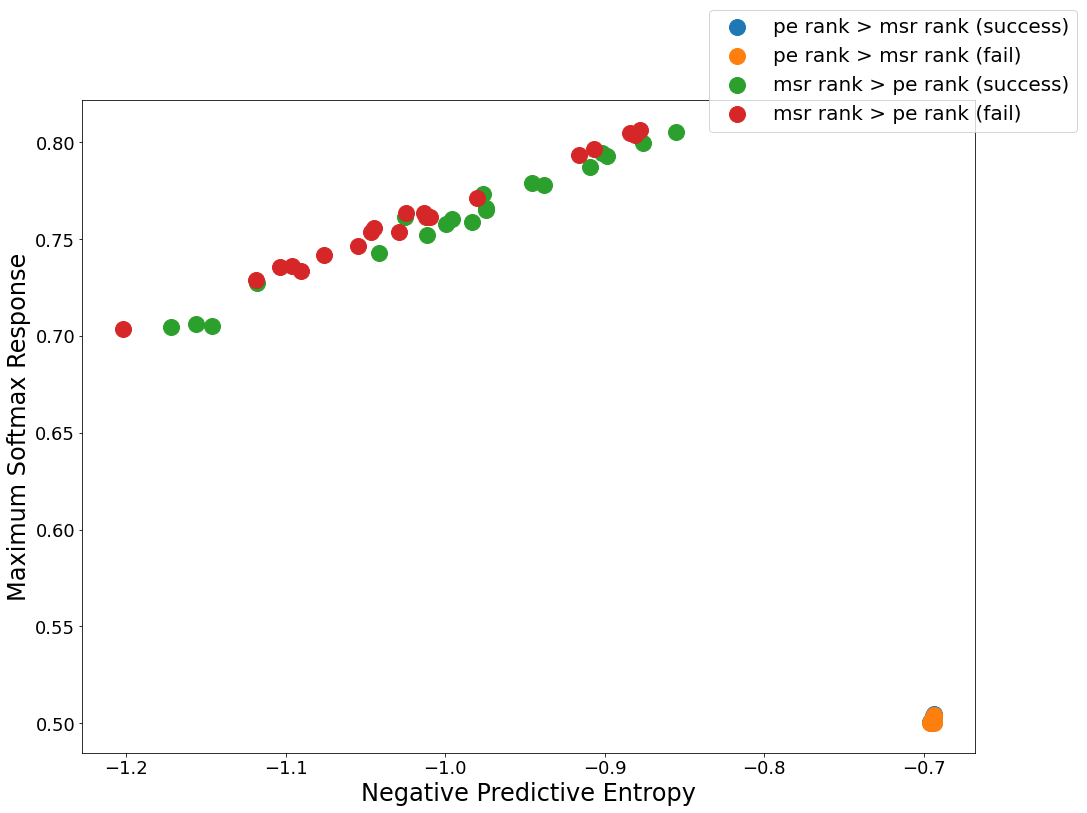

In [24]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)
pd.set_option("display.precision", 2)
pd.set_option("display.max_colwidth", None)

base_path = Path("~/Experiments/vit_64/").expanduser()

dataset = "svhn"

metrics_data: pd.DataFrame = load_metrics_csvs(dataset, base_path).pipe(
    clean_metrics_data
)

report = report_metrics(metrics_data)
representative_run = find_representative_run(metrics_data)

dataset_cache = DatasetCache(load_config(representative_run, base_path))

softmax_data = (
    load_raw_outputs(representative_run, base_path)
    .pipe(add_confid_scores)
    .pipe(compute_comparisons)
    .pipe(report_top_ranked, dataset_cache=dataset_cache)
    .pipe(plot_scatter_top_ranked)
)